## Trabajo Práctico: Red Neuronal Lineal.

aca hay que poner una introducción supongo idk



Nota: aca en el notebook usamos algunas funciones como @, qr, de NP solo para probar y comparar con
los resultados correctos. Las soluciones a todos los sistemas verdaderos y las implmentaciones de 
todas las funciones nuestras implementan cada una de estas operaciones a mano. 

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd

from alc import *
# TODO esto todo va a estar en alc cuando terminemos y hay que borrarlo
sys.path.append(".")
sys.path.append("./src")
sys.path.append("../src")
from labo00_auxiliares import *
from labo01_errores_igualdad import *
from labo02_TLs_basicas import *
from labo03_normas import *
from labo04_LU import *
from labo05_QR import *
from labo06_AVs import *
from labo07_markov import *
from labo08_SVD import *
import os


np.set_printoptions(precision=3, linewidth=150, suppress=True)

os.getcwd()[-3:]
tol = 0.01



no se explicar que hacemos las pruebas

Recordamos, los "t" son los valores de entrenamiento, y los v son los de testeo

In [2]:
Xt, Yt, Xv, Yv = cargarDataset("cats_and_dogs") 
#Xt, Yt, Xv, Yv =  cargarDatasetReducido("cats_and_dogs", 160, 200)
#print(Xt)
print(Xt.shape)
#print(Xv)
print(Xv.shape)
print(Yt, Yt.shape)
print(Yv, Yv.shape)

(1536, 2000)
(1536, 1000)
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]] (2, 2000)
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]] (2, 1000)


### QR
voy a intentar que funcione con QR que es la única que creo que ya esta implementada. 

problema: solo funciona sobre matrices cuadradas, hay que cambiar eso
problema: muy lento. vamos a cachearlo una vez calculado en un archivo para no tener que volver a hacerlo mientras testeamos cosas


In [3]:
cache_save_enabled = True
cache_load_enabled = False

def cache(calc, name):
    if cache_load_enabled and os.path.isfile(f"{name}.npy"):
        return np.load(f"{name}.npy")
    else:
        val = calc()
        if cache_save_enabled:
            np.save(f"{name}.npy", val)
        return val

def cache_many(calc, names):
    if cache_load_enabled and all([os.path.isfile(f"{name}.npy") for name in names]):
        return tuple([cache(lambda:None, name) for name in names])
    else:
        vals = calc()
        for name, val in zip(names, vals):
            cache(lambda:val, name)
        return vals
    
# no quiero perder horas de computo pq fallo un assert
def pseudoAssertEquality(X,Y, atol = tol):
    try:
        assert np.allclose(X,Y, atol=tol)
    except:
        print("ERROR: Necesita tolerancia ", np.max(np.abs(X-Y)))
    

#### Por Gram shmidt

In [4]:
tiempo = datetime.now()
Q, R = cache_many(lambda: QR_con_GS(traspuesta(Xt)), ["QGS", "RGS"])

WGS = cache(lambda:pinvGramSchmidt(Q,R,Yt), "WGS")

YvEsperadosGS = cache(lambda:matmul(WGS, Xv), "YvEsperadosGS")



ortonormalizando 100-esimo vector de 1536 a las 13:34:54.819502
ortonormalizando 200-esimo vector de 1536 a las 13:34:54.986528
ortonormalizando 300-esimo vector de 1536 a las 13:34:55.267677
ortonormalizando 400-esimo vector de 1536 a las 13:34:55.649820
ortonormalizando 500-esimo vector de 1536 a las 13:34:56.157387
ortonormalizando 600-esimo vector de 1536 a las 13:34:56.756510
ortonormalizando 700-esimo vector de 1536 a las 13:34:57.473626
ortonormalizando 800-esimo vector de 1536 a las 13:34:58.294471
ortonormalizando 900-esimo vector de 1536 a las 13:34:59.216337
ortonormalizando 1000-esimo vector de 1536 a las 13:35:00.260284
ortonormalizando 1100-esimo vector de 1536 a las 13:35:01.413813
ortonormalizando 1200-esimo vector de 1536 a las 13:35:02.679120
ortonormalizando 1300-esimo vector de 1536 a las 13:35:04.054681
ortonormalizando 1400-esimo vector de 1536 a las 13:35:05.554524
ortonormalizando 1500-esimo vector de 1536 a las 13:35:07.134442
listo resolviendo sistema
listo tr

In [5]:
print("Tardo:", (datetime.now()-tiempo).seconds, "segundos")

Tardo: 39 segundos


In [6]:


pseudoAssertEquality(Q @ R, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar
#print(YvEsperadosGS)
#print(Yv)

## comparemos con funcion numpy por si a caso
QNP,RNP = np.linalg.qr(traspuesta(Xt))
YvEsperadosNPQR = pinvGramSchmidt(QNP,RNP,Yt) @ Xv
pseudoAssertEquality(YvEsperadosGS,  YvEsperadosNPQR, atol=tol)




listo resolviendo sistema
listo trasponiendo
Calculando W


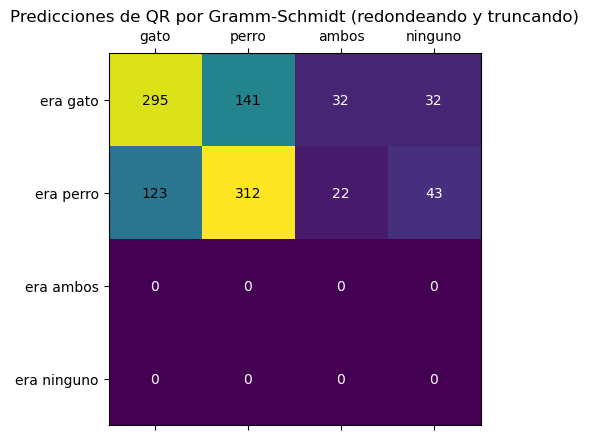

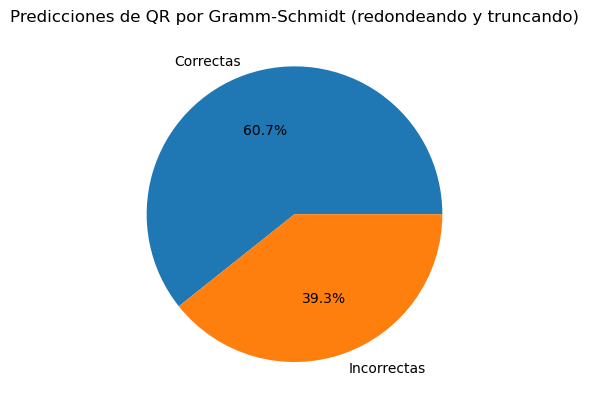

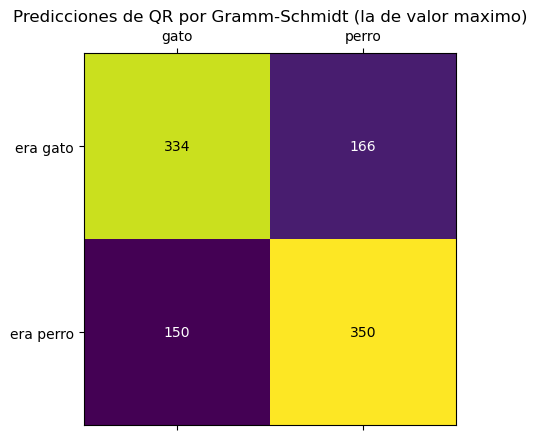

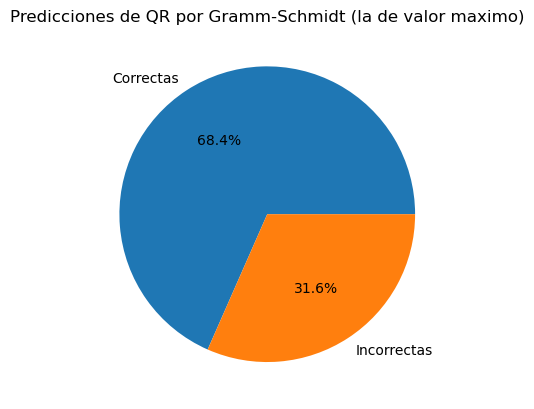

In [7]:
# medio feo tener un choclo de codigo aca pero peor era tener que importar matplotlib en ALC.py  
def graficar_predicciones_de_metodo(nombre_metodo, predicciones, valores_reales):
    gato = [1,0]
    perro = [0,1]
    gato_y_Perro = [1, 1]
    ni_gato_ni_Perro = [0, 0]

    posibilidades = [gato, perro, gato_y_Perro, ni_gato_ni_Perro]
    posibilidadesNombres = ["gato", "perro", "ambos", "ninguno"]
    confusion = np.zeros((4,4))
    
    for prediccion, valorCorrecto in zip(  np.round(np.clip(traspuesta(predicciones), 0, 1)) , np.round(traspuesta(valores_reales)) ):
        indiceY = posibilidades.index(list([int(x) for x in valorCorrecto]))
        indiceX = posibilidades.index(list([int(x) for x in prediccion]))
        confusion[ indiceY ][ indiceX ] += 1


    
    plt.matshow(confusion)
    plt.title(f"Predicciones de {nombre_metodo} (redondeando y truncando)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val < 50 else "black") 

    plt.show()
    
    pie(confusion,nombre_metodo + " (redondeando y truncando)")


    posibilidadesNombres = ["gato", "perro"]
    confusion2 = np.zeros((2,2))
    for prediccion, valorCorrecto in zip(  traspuesta(predicciones) , traspuesta(valores_reales) ):
        indiceY = int(1-valorCorrecto[0])
        indiceX = int(max(prediccion) == prediccion[1])
        confusion2[ indiceY ][ indiceX ] += 1
    
    plt.matshow(confusion2)
    plt.title(f"Predicciones de {nombre_metodo} (la de valor maximo)")
    plt.xticks(range(len(posibilidadesNombres)), posibilidadesNombres)
    plt.yticks(range(len(posibilidadesNombres)), ["era "+n for n in posibilidadesNombres ])
    
    for i ,row in enumerate(confusion2):
        for j ,val in enumerate(row):
            plt.text(j, i, f"{int(val)}", ha="center", va="center", color="white" if val < 200 else "black") 
    plt.show()
    pie(confusion2, nombre_metodo + " (la de valor maximo)")


def pie(confusion, nombre_metodo):
    correcto = 0
    incorrecto = 0
    for i in range(len(confusion)):
        correcto += confusion[i][i]

    incorrecto = len(Xv[0]) - correcto
    plt.pie([correcto, incorrecto], labels=["Correctas", "Incorrectas"], autopct='%1.1f%%')
    plt.title(f"Predicciones de {nombre_metodo}")
    plt.show()

graficar_predicciones_de_metodo("QR por Gramm-Schmidt", YvEsperadosGS, Yv)

#### Por HH

In [8]:
#tiempo = datetime.now()

#QHH, RHH = cache_many(lambda: QR_con_HH(traspuesta(Xt)), ["QHH", "RHH"])
#WHH = cache(lambda:pinvHouseHolder(QHH,RHH,Yt), "WHH")
#YvEsperadosHH = cache(lambda:matmul(WHH, Xv), "YvEsperadosHH")
#

In [9]:
#print("Tardo:", (datetime.now()-tiempo).seconds, "segundos")

In [10]:

#pseudoAssertEquality(WHH, WGS, atol=tol)
#
#pseudoAssertEquality(QHH @ RHH, traspuesta(Xt), atol=tol) # lo hago con @ solo aca para probar mas rapido
#print(f"W: {np.round(WHH,3).shape}")
#print(YvEsperadosHH)
#print(Yv)
#pseudoAssertEquality(YvEsperadosHH, YvEsperadosGS, atol=tol)





In [11]:
#graficar_predicciones_de_metodo("QR por Householder", YvEsperadosHH, Yv)


### SVD

In [12]:
tiempo = datetime.now()

U,S,V = cache_many(lambda: svd_reducida(Xt, tol=tol), ["U","S","V"])

WSVD = cache(lambda:pinvSVD(U,S,V,Yt), "WSVD")

YvEsperadosSVD = cache(lambda:matmul(WSVD, Xv), "YvEsperadosSVD")



diagonalizando 1520-esima sumbatriz a las 13:50:20.442957
diagonalizando 1500-esima sumbatriz a las 14:06:38.302549
diagonalizando 1480-esima sumbatriz a las 14:24:56.469554
diagonalizando 1460-esima sumbatriz a las 14:40:19.917518
diagonalizando 1440-esima sumbatriz a las 14:55:10.564120
diagonalizando 1420-esima sumbatriz a las 15:12:37.123770
diagonalizando 1400-esima sumbatriz a las 15:26:35.022491
diagonalizando 1380-esima sumbatriz a las 15:40:07.196620
diagonalizando 1360-esima sumbatriz a las 15:55:09.618964
diagonalizando 1340-esima sumbatriz a las 16:07:43.147879
diagonalizando 1320-esima sumbatriz a las 16:19:41.729725
diagonalizando 1300-esima sumbatriz a las 16:32:56.242831
diagonalizando 1280-esima sumbatriz a las 16:44:11.790612
diagonalizando 1260-esima sumbatriz a las 16:55:05.613677
diagonalizando 1240-esima sumbatriz a las 17:07:00.290679
diagonalizando 1220-esima sumbatriz a las 17:17:03.627205
diagonalizando 1200-esima sumbatriz a las 17:26:47.898133
diagonalizando

In [13]:
print("Tardo:", (datetime.now()-tiempo).seconds, "segundos")

Tardo: 34631 segundos


In [14]:


print(f"W: {np.round(WSVD,3).shape}")
pseudoAssertEquality(U @ np.diag(S) @ traspuesta(V), Xt, atol=tol)

print(YvEsperadosSVD)
print(Yv)


UNP,SNP,VNP = np.linalg.svd(Xt)
VNP = VNP.T[:,:Xt.shape[0]]
pseudoAssertEquality(UNP @ np.diag(SNP) @ traspuesta(VNP), Xt, atol=tol)

WSVDNP = pinvSVD(UNP,SNP,VNP,Yt)
YvEsperadosSVDNP = WSVDNP @ Xv

pseudoAssertEquality(YvEsperadosSVD, YvEsperadosSVDNP, atol=tol)


W: (2, 1536)
[[-0.202  0.034 -0.297 ...  0.466  2.485  0.394]
 [ 0.951  0.335  1.364 ...  0.453 -0.563  0.315]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]
ERROR: Necesita tolerancia  0.24037149125333912


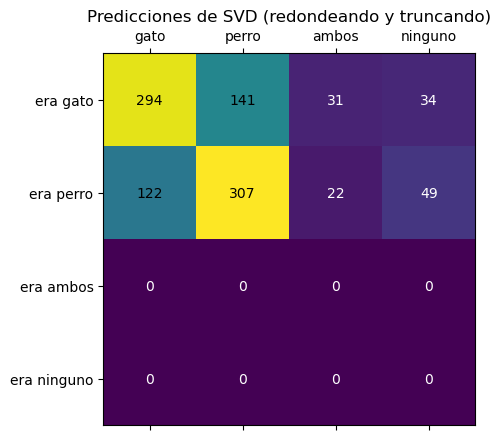

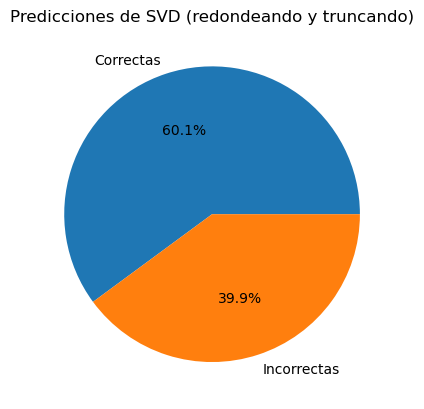

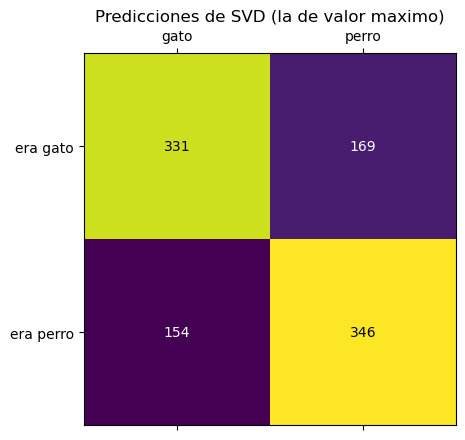

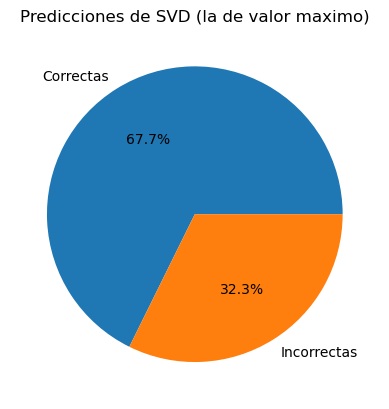

In [15]:
graficar_predicciones_de_metodo("SVD", YvEsperadosSVD, Yv)

### Cholesky / Ecuaciones Normales

In [16]:
tiempo = datetime.now()

LCholesky = cache(lambda: cholesky(matmul(Xt, traspuesta(Xt))), "LCholesky")

WEqNorm = cache(lambda:pinvEcuacionesNormales(Xt,LCholesky,Yt), "WEN")

YvEsperadosEqNorm = cache(lambda:matmul(WEqNorm, Xv), "YvEsperadosEqNorm")



choleskizando 0-esima columna a las 23:15:00.872381
choleskizando 100-esima columna a las 23:15:01.579553
choleskizando 200-esima columna a las 23:15:02.273472
choleskizando 300-esima columna a las 23:15:02.936553
choleskizando 400-esima columna a las 23:15:03.557087
choleskizando 500-esima columna a las 23:15:04.148240
choleskizando 600-esima columna a las 23:15:04.704721
choleskizando 700-esima columna a las 23:15:05.207638
choleskizando 800-esima columna a las 23:15:05.662522
choleskizando 900-esima columna a las 23:15:06.069080
choleskizando 1000-esima columna a las 23:15:06.423994
choleskizando 1100-esima columna a las 23:15:06.721075
choleskizando 1200-esima columna a las 23:15:06.962318
choleskizando 1300-esima columna a las 23:15:07.140841
choleskizando 1400-esima columna a las 23:15:07.259371
choleskizando 1500-esima columna a las 23:15:07.315030


In [17]:
print("Tardo:", (datetime.now()-tiempo).seconds, "segundos")

Tardo: 95 segundos


In [18]:

print(f"W: {np.round(WEqNorm,3).shape}")
pseudoAssertEquality(LCholesky @ traspuesta(LCholesky), matmul(Xt, traspuesta(Xt)), atol=tol)

print(YvEsperadosEqNorm)
print(Yv)


LCholeskyNP = np.linalg.cholesky(Xt @ Xt.T)

WWEqNormNP = pinvEcuacionesNormales(Xt, LCholeskyNP, Yt)
YvEsperadosEqNormNP = WWEqNormNP @ Xv
# es tan inestable que este assert puede fallar!
# assert np.allclose(YvEsperadosEqNormNP, YvEsperadosEqNorm, atol=0.01)


W: (2, 1536)
[[-0.253  0.005 -0.255 ...  0.402  2.461  0.403]
 [ 1.027  0.345  1.371 ...  0.507 -0.557  0.306]]
[[0 0 0 ... 1 1 1]
 [1 1 1 ... 0 0 0]]


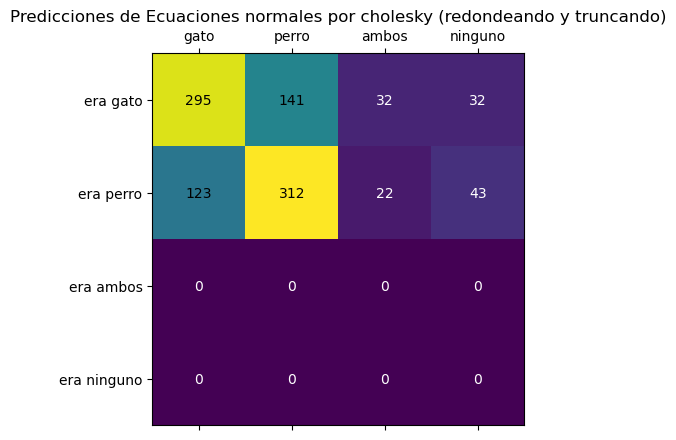

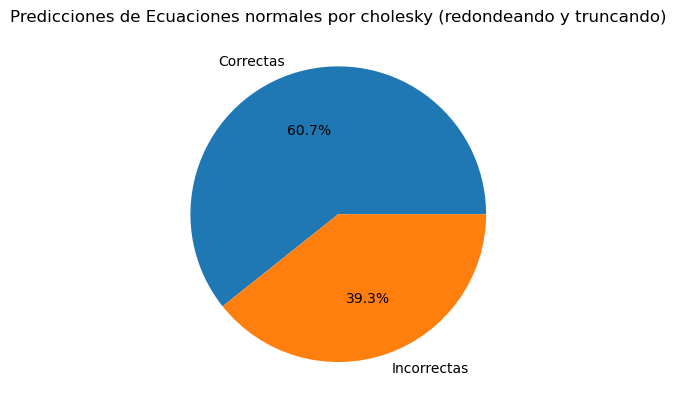

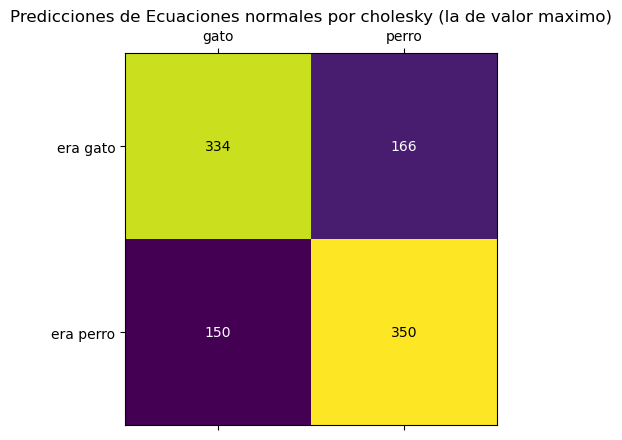

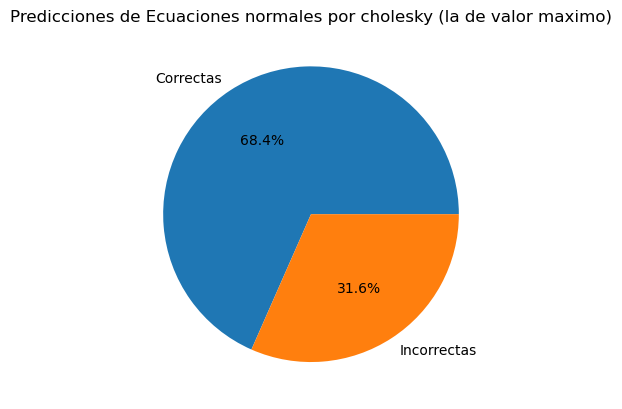

In [19]:
graficar_predicciones_de_metodo("Ecuaciones normales por cholesky", YvEsperadosEqNorm, Yv)